# <center>The Basics of Best Subset Selection with Bonus Section on Bias in Regularized Linear Models<center>
    
### <center>By John Clements<center>

## I. Introduction to Best Subset Selection

As there is a lot of buzz about AutoML, I thought about writing about the original AutoML; step-wise regression and best subset selection. Then I decided to ignore step-wise regression because it is bad and should probably stop being taught. That leaves best subset selection to discuss.

The idea behind best subset selection is choose the "best" subset of variables to include in a model. We determine which set of variables are "best" by assessing which sub-model fits the data best while penalizing for the number of independent variables in the model to avoid over-fitting. There are multiple metrics for assessing how well a model fits: adjusted $R^2$, the Akaike Information Criterion (AIC), the Bayesian Information Criterion (BIC), and Mallow's $C_p$ are probably the best known.

The formulas for each are below.

### 1. Adjusted $R^2$

$R^{2}_{adj} = 1 - \frac{(1 - R^2)(n - 1)}{n - k - 1}$, where $R^2$ is the coefficient of determination, $n$ = # of observations, and $k$ = number of variables.

### 2. Akaike Information Criterion (AIC)

### $AIC = 2k - 2ln(\hat{L})$

Where $k$ = # of estimated parameters in the model and $\hat{L}$ is the maximum value of the likelihood function for the model. Maximum Likelihood Estimation requires its own article to explain, so I won't do so here.

### 3. Bayesian Information Criterion (BIC)

### $BIC = kln(n) - 2ln(\hat{L})$

Where $n$ = # of observations, $k$ = # of estimated parameters in the model, and $\hat{L}$ is the maximum value of the likelihood function for the model.

### 4. Mallow's $C_p$

### $C_p = \frac{SSE_p}{MSE_{full}} - n + 2(p + 1)$

Where $p$ = # of variables in the subset, $SSE_p$ = Sum of Squared Errors for the model with the $p$ predictors, $MSE_{full}$ = the Mean Squared Error of the model with all variables included, and $n$ = # of observations. Formulas and definitions for $SSE$ and $MSE$ can be found by reading up on linear regression.

With Adjusted $R^2$, you want to find the model with the largest Adjusted $R^2$ because it explains the most variance in the dependent variable, penalized for model complexity. For the others, you want to find the model with the smallest Information Criterion because it is the model with the least unexplained variance in the dependent variable, penalizing for model complexity. They're the same idea, i.e. maximizing something good versus minimizing something bad.

Both the AIC and Mallow's $C_p$ tend to give better predictive models, while BIC tends to give models with fewer independent variables because it penalizes complex models more than other two.

Like most things in life, automating model selection comes at a cost. If you use your data to select a linear model, the coefficients of the selected variables will be *biased* away from zero! The null hypotheses of both the individual t-tests for each coefficient and the F-test for overall model significance are based on the assumption that each coefficient is normally distributed with mean 0. Since we have introduced bias into our coefficients, the Type I error level increases for these tests! This may not be an issue if you just need a predictive model, but it completely invalidates any statistical inferences made with the selected model. AutoML may be able to generate decent predictive models, but inference still requires a person to think carefully about the problem and follow the scientific method.

## II. Demonstrating the Bias of Best Subset Selection

I performed a simulation study to demonstrate the bias caused by best subset selection. Instead of looking at the bias in the coefficients, we will look at the bias in the estimated standard deviation of the error term in the model $y_i = \beta_0 + \beta_1 * x_{i,1} + ... + \beta_k * x_{i,k} + \epsilon_i$, where the error terms are identically and independently distributed $N(0, \sigma)$ random variables.

At each round of the simulation, a sample of 100 observations are generated from the same distribution. The true model, which contains only the truly significant variables, as well as the best subset models selected by AIC and BIC are also estimated. From each model, I estimate the $\sigma$ of the error term using the formula $\hat{\sigma} = \sqrt{\frac{\sum{(y_i - \hat{y_i})^2}}{n - k - 1}}$, where $y_i$ is the actual value of the $i^{th}$ dependent variable, $\hat{y_i}$ is the predicted value of the $i^{th}$ dependent variable, $n$ is the number of obseravations, and $k$ is the number of independent variables in the model. This is performed 500 times.

The particular parameters of my simulation are as follows: $n$ = 100, # of independent variables = 6, $\sigma$ = 1, and the number of significant independent variables is 2. The intercept is significant as well, so 3 coefficients are non-zero. The non-zero coefficients are selected using random $N(5, 1)$ numbers because I am too lazy to define fixed numbers, but they remain fixed for all rounds of the simulation.

I first defined my own function to perform best subset selection using AIC or BIC using a naive approach by looking at every combination of variables. It only works for a small number of variables because the number of models it has to consider blows up as the number of variables increases. The number of models considered is $\sum^{k}_{p=1}{C^{k}_{p}}$, but smarter implementations of best subset selection use a tree search to reduce the number of models considered.

The graphs of interest are below these chunks of code for the best subset selection function and for the simulation.

In [1]:
def best_information_criterion_selection(y, X, criterion='AIC'):
    '''
    This function takes in a column numpy array (y) and design matrix (X) (with the first column as all 1s for
    the intercept) which is also a numpy array, and returns the OLS model with the lowest Information 
    Criterion. The default criterion is AIC; and the other option is BIC.
    '''
    
    # check inputs are valid
    assert y.shape[0] == X.shape[0], 'The number of rows in y and X do not match!'
    assert (criterion == 'AIC') or (criterion == 'BIC'), 'Valid criterions are AIC and BIC!'
    
    # for linear regression
    import statsmodels.api as sm
    # for generating combinations of explanatory variables for model selection based on AIC
    from itertools import combinations
    
    # calculate the number of non-intercept predictors in the design matrix
    number_of_predictors = X.shape[1] - 1
    
    # create an array of the column numbers of the predictors
    var_cols = np.arange(1, number_of_predictors + 1, step=1)
    
    # create an empty list to hold all possible combinations of the predictor columns from 1 to all
    subsets_of_vars = []
    ###
    # This nested for loop appends all possible combinations of predictor columns from just 1 variable to 
    # all number_of_predictors
    ###
    for num_predictors in range(1, number_of_predictors + 1):
        for subset in combinations(var_cols, num_predictors):
            subsets_of_vars.append(subset)
    
    # create an array of zeros to hold the Information Criterion of each model
    Info_Criterions = np.zeros(shape=len(subsets_of_vars))
    
    # create an empty list to hold the models
    models = []
    
    # create a counter to be used for indexing in Info_Criterions and temp_biased_var_estimates
    counter = 0
    
    # loop through all subsets of predictors
    for subset in subsets_of_vars:
        
        # select the temporary subset of our design matrix
        temp_X = X[:, (0,) + subset]
        
        # fit an OLS linear model to the temporary data
        temp_OLS_mod = sm.OLS(temp_y, temp_X).fit()
        
        if criterion == 'AIC':
            # add the AIC to the Info_Criterions array at the counter th slot
            Info_Criterions[counter] = temp_OLS_mod.aic
            
        else:
            # add the AIC to the Info_Criterions array at the counter th slot
            Info_Criterions[counter] = temp_OLS_mod.bic
        
        # add the biased estimate to the temp_biased_var_estimates array at the counter th slot
        models.append(temp_OLS_mod)
        
        # increment the counter
        counter += 1
    
    # find the index of the model with the lowest Information Criterion
    lowest_IC_index = np.argmin(Info_Criterions)
    
    # return the model with the lowest Information Criterion
    return models[lowest_IC_index]

In [2]:
# for linear algebra and random numbers
import numpy as np
# for linear regression
import statsmodels.api as sm
# for visualization
import matplotlib.pyplot as plt
# for generating combinations of explanatory variables for model selection based on AIC
from itertools import combinations

# set a random seed for reproducibility
np.random.seed(123)

# set the number of simulations to run
num_sims = 500

# set n and k and make a n by k+1 matrix of standard normal random numbers
n = 100
k = 6

# set the number of predictors, including the intercept that are significant
k_significant = 3

# create a column vector of zeros, with k + 1 betas, where the first value is the true intercept
beta = np.zeros(shape=(k + 1, 1))
# set the first k_significant betas to be non-zero values, using iid N(3, 1) random variables
beta[:k_significant] = np.random.normal(loc=5.0, scale=1.0, size=(k_significant, 1))

# create an array of zeros to hold our UNBIASED estimates of the standard deviation of our error term
unbiased_sigma_estimates = np.zeros(shape=num_sims)
# create an array of zeros to hold our BIASED estimates of the standard deviation of our error term (from AIC)
aic_sigma_estimates = np.zeros(shape=num_sims)        
# create an array of zeros to hold our BIASED estimates of the standard deviation of our error term (from BIC)
bic_sigma_estimates = np.zeros(shape=num_sims)

# perform num_sims simulations
for i in range(num_sims):
    
    ###
    # This block generates the random sample
    ###
    
    # create the temporary design n by k + 1 design matrix
    temp_X = np.random.normal(loc=0.0, scale=1.0, size=(n, k + 1))
    
    # set the first column of the design matrix to 1.0 to include an intercept
    temp_X[:,0] = 1.0
    
    # create temporary y values using the design matrix and beta vector, and add standard normal random noise
    temp_y = np.matmul(temp_X, beta) + np.random.normal(loc=0.0, scale=1.0, size=(n, 1))
    
    
    ###
    # This block estimates the standard deviation using the True OLS model
    ###
    
    # fit an OLS linear model to the temporary data
    temp_true_mod = sm.OLS(temp_y, temp_X[:,0:k_significant]).fit()
    
    # estimate the standard deviation of the error term 
    temp_unbiased_sigma_estimate = np.sqrt(np.sum(temp_true_mod.resid **2) / 
                                         (n - temp_true_mod.params.shape[0]))
    # add the unbiased estimate to the array at the ith slot
    unbiased_sigma_estimates[i] = temp_unbiased_sigma_estimate  
    
    
    ###
    # This block estimates the standard deviation using the OLS model with best subset selection of variables 
    # using AIC
    ###
    
    # select the model with the lowest information criterion
    temp_best_AIC_mod = best_information_criterion_selection(temp_y, temp_X, criterion='AIC')
    # estimate the standard deviation of the error term 
    temp_aic_sigma_estimate = np.sqrt(np.sum(temp_best_AIC_mod.resid ** 2) / temp_best_AIC_mod.df_resid)
    # add the unbiased estimate to the array at the ith slot
    aic_sigma_estimates[i] = temp_aic_sigma_estimate  
    
    
    ###
    # This block estimates the standard deviation using the OLS model with best subset selection of variables 
    # using BIC
    ###
    
    # select the model with the lowest information criterion
    temp_best_BIC_mod = best_information_criterion_selection(temp_y, temp_X, criterion='BIC')
    # estimate the standard deviation of the error term 
    temp_bic_sigma_estimate = np.sqrt(np.sum(temp_best_BIC_mod.resid ** 2) / temp_best_BIC_mod.df_resid)
    # add the unbiased estimate to the array at the ith slot
    bic_sigma_estimates[i] = temp_bic_sigma_estimate

As you can see in the plots below, the estimates of $\sigma$ are biased. In fact they will always be less than or equal to the unbiased estimate of $\sigma$ from the true model. This demonstrates why models selected via automatic methods are invalid for inference.

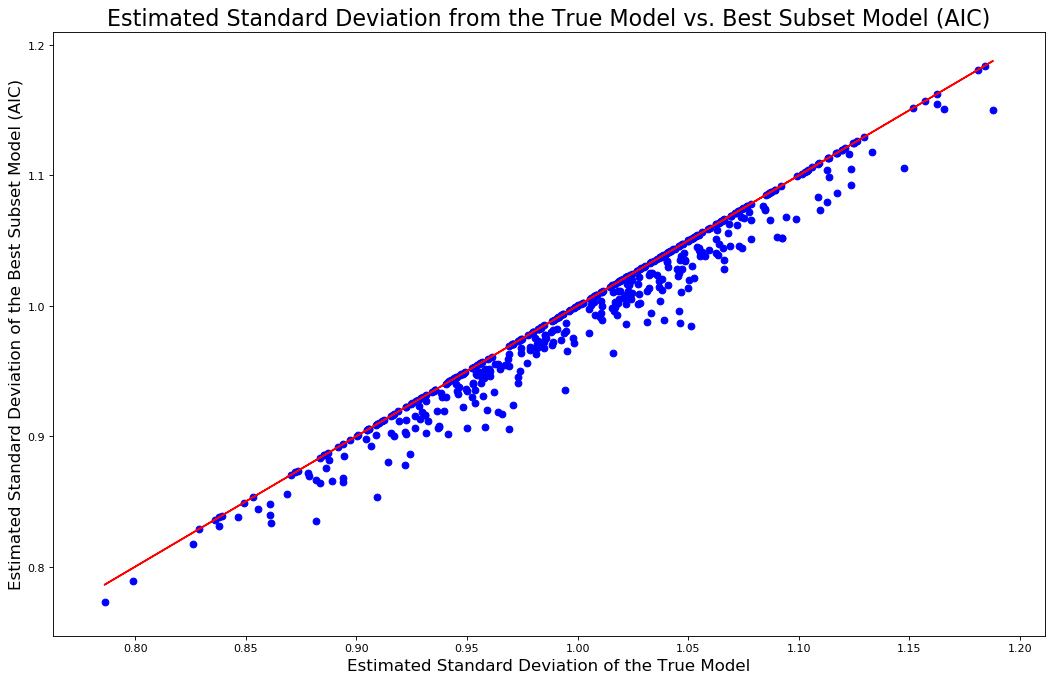

In [3]:
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.scatter(unbiased_sigma_estimates, aic_sigma_estimates, c='blue')
plt.plot(unbiased_sigma_estimates, unbiased_sigma_estimates, c='red')
plt.title('Estimated Standard Deviation from the True Model vs. Best Subset Model (AIC)', fontsize=20)
plt.xlabel('Estimated Standard Deviation of the True Model', fontsize=15)
plt.ylabel('Estimated Standard Deviation of the Best Subset Model (AIC)', fontsize=15)
plt.show();

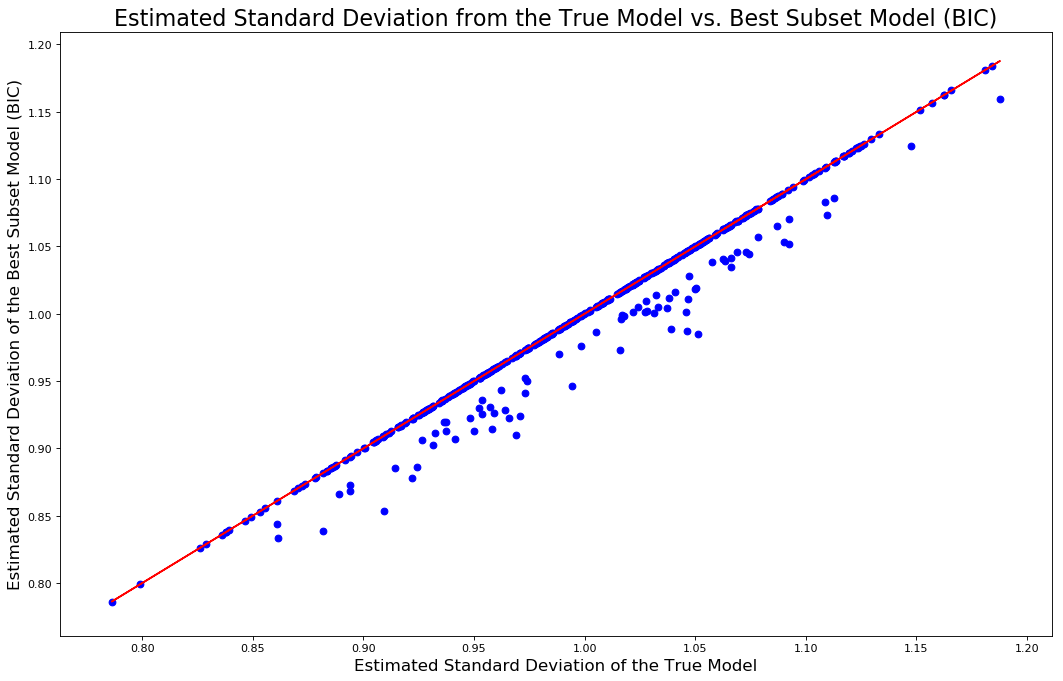

In [4]:
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.scatter(unbiased_sigma_estimates, bic_sigma_estimates, c='blue')
plt.plot(unbiased_sigma_estimates, unbiased_sigma_estimates, c='red')
plt.title('Estimated Standard Deviation from the True Model vs. Best Subset Model (BIC)', fontsize=20)
plt.xlabel('Estimated Standard Deviation of the True Model', fontsize=15)
plt.ylabel('Estimated Standard Deviation of the Best Subset Model (BIC)', fontsize=15)
plt.show();

## III. Bonus Section: Investigating Bias in Estimated Standard Deviation of the Error term in LASSO and Ridge Regression

While working on the simulation study above, I became interested in the potential bias of regularization methods on estimates of the standard deviation of the error term in a linear model. As you most likely know, LASSO and Ridge regression intentionally bias estimated coefficients towards zero to reduce the amount of variance in the model (how much estimated coefficients change from sample to sample from the same population). I wanted to know if there was a similar effect for the estimate of the standard deviation, as seen with best subset selection using AIC and BIC.

I used the same set up as before, but upped the sample size from 100 to 200, the number of independent variables from 6 to 100, and the number of significant independent variables from 2 to 50. The shrinkage parameter in both the LASSO and Ridge models were chosen among 0.01, 0.1, 1.0, and 10.0 using 3-fold cross validation. I counted the number of non-zero coefficients in the LASSO model for purposes of calculating $\hat{\sigma}$ and used all 100 for the Ridge model, since it biases coefficients to zero, but doesn't set them to zero.

Obviously, regularized linear models are not valid for the purposes of inference because they bias estimates of coefficients. I still thought investigating any bias in the estimated standard deviation of the error term was worth writing a little code.

The plots are below this code chunk for the simulations.

In [5]:
# suppresses warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# import LassoCV
from sklearn.linear_model import LassoCV
# import RidgeCV
from sklearn.linear_model import RidgeCV

# set the number of simulations to run
num_sims = 500

# set n and k and make a n by k+1 matrix of standard normal random numbers
n = 200
k = 100

# set the number of predictors, including the intercept that are significant
k_significant = 51

# create a column vector of zeros, with k + 1 betas, where the first value is the true intercept
beta = np.zeros(shape=(k + 1, 1))
# set the first k_significant betas to be non-zero values, using random N(10, 2) random variables
beta[:k_significant] = np.random.normal(loc=5.0, scale=1.0, size=(k_significant, 1))

# create an array of zeros to hold our UNBIASED estimates of the variance of our error term (from OLS)
unbiased_sigma_estimates = np.zeros(shape=num_sims)
# create an array of zeros to hold our LASSO estimates of the variance of our error term (from OLS)
lasso_sigma_estimates = np.zeros(shape=num_sims)
# create an array of zeros to hold our LASSO estimates of the variance of our error term (from OLS)
ridge_sigma_estimates = np.zeros(shape=num_sims)

# perform num_sims simulations
for i in range(num_sims):
    
    ###
    # This block generates the random sample
    ###
    
    # create the temporary design n by k + 1 design matrix
    temp_X = np.random.normal(loc=0.0, scale=1.0, size=(n, k + 1))
    
    # set the first column of the design matrix to 1.0 to include an intercept
    temp_X[:,0] = 1.0
    
    # create temporary y values using the design matrix and beta vector, and add standard normal random noise
    temp_y = np.matmul(temp_X, beta) + np.random.normal(loc=0.0, scale=1.0, size=(n, 1))
    
    
    ###
    # This block estimates the variance using the true model
    ###
    
    # fit an OLS linear model to the temporary data
    temp_true_mod = sm.OLS(temp_y, temp_X[:,0:k_significant]).fit()
    
    # estimate the variance of the error term (note: ddof=1 is to use the sample variance formula)
    temp_unbiased_sigma_estimate = np.sqrt(np.sum(temp_true_mod.resid **2) / 
                                         (n - temp_true_mod.params.shape[0]))
    
    # add the unbiased estimate to the array at the ith slot
    unbiased_sigma_estimates[i] = temp_unbiased_sigma_estimate 
    
    
    ###
    # This block estimates the variance using the LASSO model with the best alpha chosen by cross-validation
    ###
    
    # create an instance of a LASSO model
    lasso_mod = LassoCV(alphas=(0.01, 0.1, 1.0, 10.0), fit_intercept=False, cv=3)
    
    # reshape temp_y to be compatible with sklearn standards
    reshaped_temp_y = temp_y.reshape(temp_y.shape[0])
    
    # fit the LASSO model with the best alpha
    fit_lasso_mod = lasso_mod.fit(temp_X, reshaped_temp_y)
    
    # calculate the residuals from the temporary LASSO model
    temp_lasso_resids = reshaped_temp_y - fit_lasso_mod.predict(temp_X)
    
    # count the number of non-zero parameters in the LASSO model
    non_zero_param_count = (fit_lasso_mod.coef_ != np.repeat(0, fit_lasso_mod.coef_.shape[0])).sum()
    
    # estimate the standard deviation of the error term
    temp_lasso_sigma_estimate = np.sqrt(np.sum(temp_lasso_resids ** 2) / (n - non_zero_param_count))
                            
    # add the unbiased estimate to the array at the ith slot
    lasso_sigma_estimates[i] = temp_lasso_sigma_estimate 
    
    
    ###
    # This block estimates the variance using the Ridge model with the best alpha chosen by cross-validation
    ###
    
    # create an instance of a ridge model
    ridge_mod = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0), fit_intercept=False, cv=3)
    
    # reshape temp_y to be compatible with sklearn standards
    reshaped_temp_y = temp_y.reshape(temp_y.shape[0])
    
    # fit the ridge model with the best alpha
    fit_ridge_mod = ridge_mod.fit(temp_X, reshaped_temp_y)

    # calculate the residuals from the temporary ridge model
    temp_ridge_resids = reshaped_temp_y - fit_ridge_mod.predict(temp_X)
    
    # estimate the variance of the error term (note: ddof=1 is to use the sample variance formula)
    temp_ridge_sigma_estimate = np.sqrt(np.sum(temp_ridge_resids ** 2) / (n - k - 1))
    
    # add the unbiased estimate to the array at the ith slot
    ridge_sigma_estimates[i] = temp_ridge_sigma_estimate 

By visual inspection, estimates of the error term's standard deviation do appear downwardly biased in the LASSO models, but the unbiased estimate doesn't form an upper bound as it does with the best AIC and BIC models. The Ridge models do not show obvious bias. Let's investigate with a paired t-test, since the estimates are derived from the same sample at each iteration. I'm using the standard p-value cutoff of 0.05, because I'm too lazy to decide my desired power of the test.

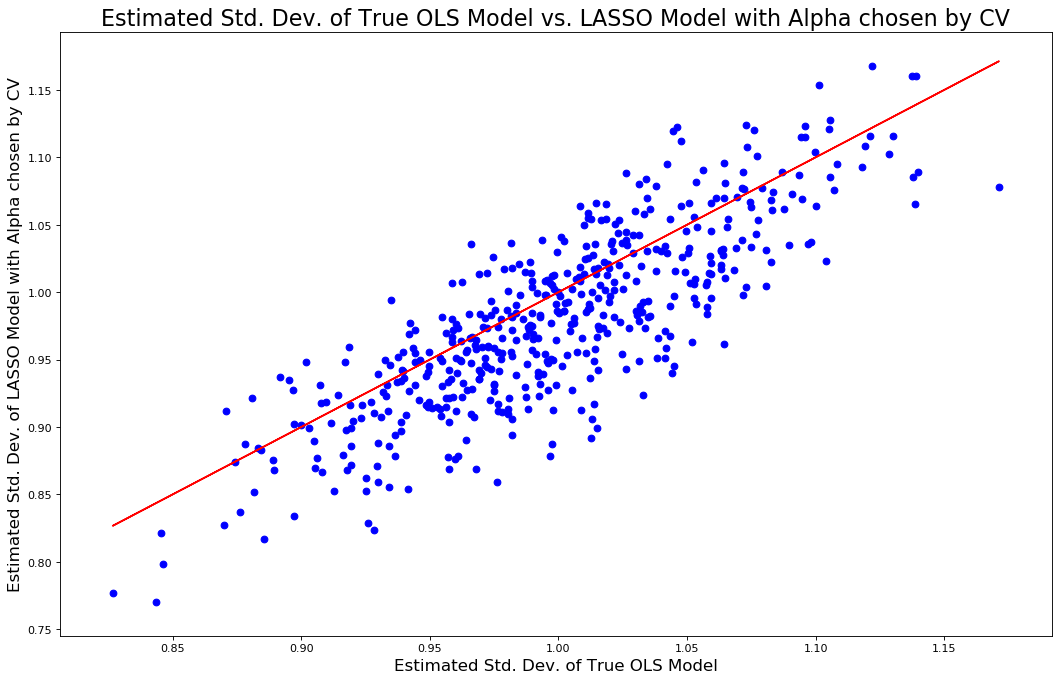

In [6]:
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.scatter(unbiased_sigma_estimates, lasso_sigma_estimates, c='blue')
plt.plot(unbiased_sigma_estimates, unbiased_sigma_estimates, c='red')
plt.title('Estimated Std. Dev. of True OLS Model vs. LASSO Model with Alpha chosen by CV', fontsize=20)
plt.xlabel('Estimated Std. Dev. of True OLS Model', fontsize=15)
plt.ylabel('Estimated Std. Dev. of LASSO Model with Alpha chosen by CV', fontsize=15)
plt.show();

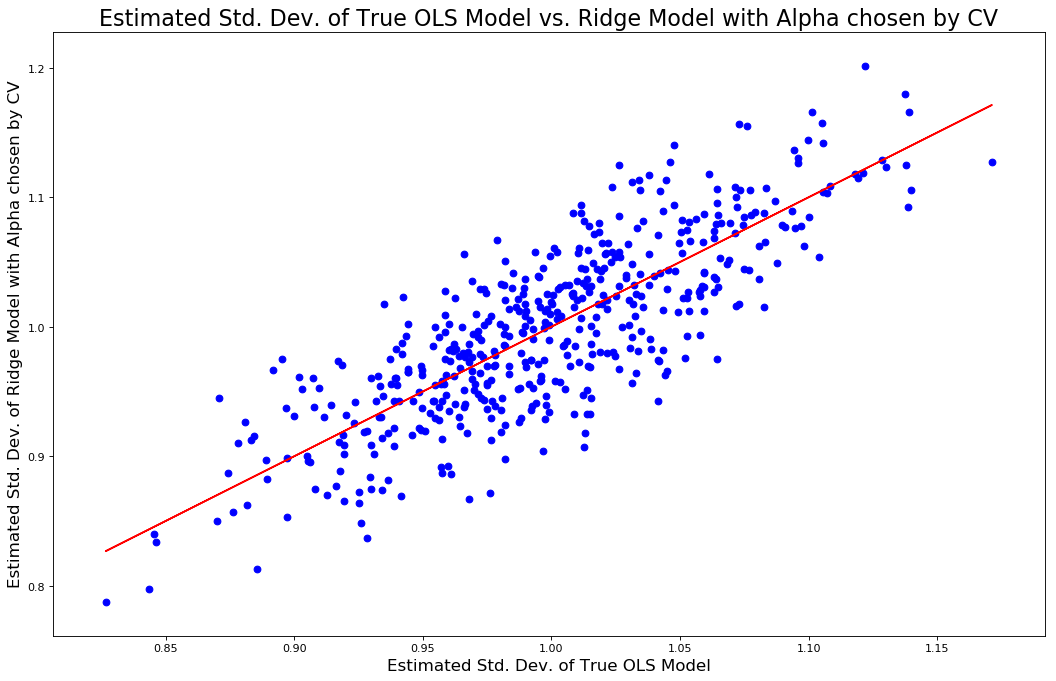

In [7]:
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')

plt.scatter(unbiased_sigma_estimates, ridge_sigma_estimates, c='blue')
plt.plot(unbiased_sigma_estimates, unbiased_sigma_estimates, c='red')
plt.title('Estimated Std. Dev. of True OLS Model vs. Ridge Model with Alpha chosen by CV', fontsize=20)
plt.xlabel('Estimated Std. Dev. of True OLS Model', fontsize=15)
plt.ylabel('Estimated Std. Dev. of Ridge Model with Alpha chosen by CV', fontsize=15)
plt.show();

In [8]:
# for the paired t-test for differnce of means
from scipy.stats import ttest_rel

# save and printprint the results of the test on the Ridge estimates
lasso_results = ttest_rel(unbiased_sigma_estimates, lasso_sigma_estimates)
print(f'Test Statistic for the Paired t-test between the True Model and LASSO: {round(lasso_results[0], 4)}')
print(f'p-value for the Paired t-test between the True Model and LASSO: {round(lasso_results[1], 4)}')
print()
# save and printprint the results of the test on the Ridge estimates
ridge_results = ttest_rel(unbiased_sigma_estimates, ridge_sigma_estimates)
print(f'Test Statistic for the Paired t-test between the True Model and Ridge: {round(ridge_results[0], 4)}')
print(f'p-value for the Paired t-test between the True Model and Ridge: {round(ridge_results[1], 4)}')

Test Statistic for the Paired t-test between the True Model and LASSO: 11.0345
p-value for the Paired t-test between the True Model and LASSO: 0.0

Test Statistic for the Paired t-test between the True Model and Ridge: 0.0567
p-value for the Paired t-test between the True Model and Ridge: 0.9548


As guessed by the visual inspection, there is insufficient evidence for a difference in means between the estimates of $\hat{\sigma}$ between the true and Ridge models. However, there is sufficient evidence at the 0.05 significance level to conclude that the LASSO models tended to generate downwardly biased estimates of $\hat{\sigma}$. Whether or not this is a generalizable fact is unknown. It would require a formal proof to make a conclusion.